In [470]:
from stochastic import stochastic_dual, discrete_map_learning, continuous_map_learning
from sinkhorn import sinkhorn
from closed_form import closed_form_projection, closed_form_gaussian_pi, closed_form_gaussian_T
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc # for latex

In [471]:
# Plot the history of the dual objective function :

def plot_sinkhorn_history(history):
    # history : {dual, iter, time, n_samples, TV(pi, pi_GT)}
    # plot dual = f(iter)
    # plot TV(pi, pi_GT) = f(iter)
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Dual objective', color=color)
    ax1.plot(history["iter"], history["dual"], color=color, label=r'$\mathcal{D}^{\epsilon}(u, v)$')
    # ax1.plot(history["iter"], history["primal"], color='tab:cyan', label='Primal objective')
    # ax1.plot(history["iter"], history["Transport Cost"], color='b', label='Transport Cost')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Total Variation (TV)', color='tab:red')  # we already handled the x-label with ax1
    ax2.loglog(history["iter"], history["TV_to_mu"], color='tab:orange', label=r'$TV(\pi_1, \mu)$')
    ax2.loglog(history["iter"], history["TV_to_nu"], color='tab:green', label=r'$TV(\pi_2, \nu)$')

    # if "TV(pi, pi_GT)" in history:
    #     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    #     color = 'tab:red'
    #     ax2.set_ylabel('TV(pi, pi_GT)', color=color)  # we already handled the x-label with ax1
    #     ax2.plot(history["iter"], history["TV(pi, pi_GT)"], color=color)
    #     ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(loc='upper right')
    plt.show()

def plot_dual_history(history, sink_dual, plot_TV=True):
    def adaptive_smooth(data, min_window=5, max_window=500):
        smoothed = []
        for i in range(len(data)):
            # Increase the window size proportionally with the iteration index
            window_size = min(max(min_window, i // 100), max_window)
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2)
            smoothed.append(np.mean(data[start:end]))
        return np.array(smoothed)
    
    fig, ax2 = plt.subplots()

    if plot_TV:
        # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        ax2.set_ylabel('Total Variation (TV)', color=color)  # we already handled the x-label with ax1
        # ax2.set_yscale('log')
        smoothed_mu = adaptive_smooth(history["TV_to_mu"])
        smoothed_nu = adaptive_smooth(history["TV_to_nu"])
        ax2.loglog(range(len(smoothed_mu)), smoothed_mu, color='tab:orange', label=r'$TV(\pi_1, \mu)$')
        ax2.loglog(range(len(smoothed_nu)), smoothed_nu, color='tab:green', label=r'$TV(\pi_2, \nu)$')
        # if "TV(pi, pi_GT)" in history:
        #     ax2.loglog(history["iter"], history["TV(pi, pi_GT)"], color='black', label='TV(pi, pi_GT)')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        ax2.legend(loc='upper left')

    if plot_TV:
        ax1 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
    else:
        ax1 = ax2
    color = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Dual objective', color=color)
    # ax1.plot(history["iter"], history["dual"], color=color)
    # Smooth the dual curve using local averages
    smoothed_dual = adaptive_smooth(history["dual"])
    # smoothed_primal = adaptive_smooth(history["primal"])
    # smoothed_TC = adaptive_smooth(history["Transport Cost"])
    ax1.plot(range(len(smoothed_dual)), smoothed_dual, color='tab:blue', label=r'$\mathcal{D}^{\epsilon}(u, v)$')
    # ax1.plot(range(len(smoothed_primal)), smoothed_primal, color='tab:cyan', label='Primal objective')
    # ax1.plot(range(len(smoothed_TC)), smoothed_TC, color='b', label='Transport Cost')
    if sink_dual is not None:
        ax1.axhline(y=sink_dual['dual'][-1], color='tab:blue', linestyle='--', label='Sinkhorn dual objective')
    ax1.legend(loc='upper right')
    plt.show()

def plot_map_history(hist, L, MSE, time=True):
        fig, ax1 = plt.subplots()

        window_size = 5

        color = 'tab:blue'
        x_label = 'Time' if time else 'Iteration'
        k = 'time' if time else 'iter'
        ax1.set_xlabel(x_label)
        ax1.set_ylabel('Loss', color=color)
        def smooth(data, window_size=50):
            smoothed = []
            for i in range(len(data)):
                start = max(0, i - window_size // 2)
                end = min(len(data), i + window_size // 2)
                smoothed.append(np.mean(data[start:end]))
            return np.array(smoothed)
            
        smooth_loss = smooth(hist["L"])
        ax1.loglog(hist[k], smooth_loss, color=color, label='Loss')
        if L is not None:
            ax1.axhline(y=L, color=color, linestyle='--', label='Reference Loss')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        ax2.set_ylabel('MSE', color=color)  # we already handled the x-label with ax1
        smooth_mse = smooth(hist["MSE T(X1) - Monge_map"])
        ax2.loglog(hist[k], smooth_mse, color=color, label=r'$MSE(T(X), T_{\mathrm{Monge}}(X))$')
        if MSE is not None:
            ax2.axhline(y=MSE, color=color, linestyle='--', label=r'$MSE(T_{\mathrm{bary}}(X), T_{\mathrm{Monge}}(X))$')
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.legend(loc='upper right')
        plt.show()

In [472]:
# Trivial test case : X1 = X2, mu = nu

n_samples = 1000
batch_size = 100
n_features = 3
sigma = 1e-1
X1 = torch.rand(n_samples, n_features) * sigma
X2 = X1
# mu = torch.ones(n_samples) / n_samples
# nu = mu
mu = torch.rand(n_samples) * 10
mu = torch.nn.functional.softmax(mu, dim=0)
nu = mu
# nu = torch.rand(n_samples) * 10
# nu = torch.nn.functional.softmax(nu, dim=0)

epsilon = 1e0

C = torch.cdist(X1, X2, p=2) ** 2

In [473]:
pi_ref = torch.eye(n_samples)
pi_ref = pi_ref / pi_ref.sum()

transport_cost = torch.sum(pi_ref * C)
primal = torch.sum(pi_ref * C) + epsilon * torch.sum(pi_ref * (torch.log(pi_ref + 1e-20)))
# dual = torch.sum(mu * u_) + torch.sum(nu * v_) - epsilon * torch.sum(torch.exp((u_[:, None] + v_[None, :] - C) / epsilon) * mu[:, None] * nu[None, :]) + epsilon
print(f"Transport cost: {transport_cost}")
print(f"Primal: {primal}")

Transport cost: 1.2508827307300407e-10
Primal: -6.9077558517456055


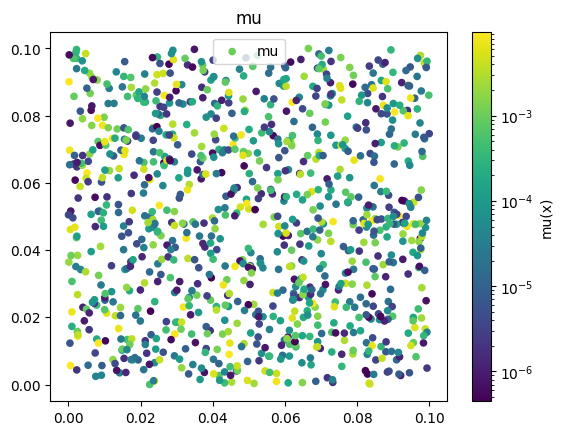

In [474]:
plt.scatter(X1[:, 0], X1[:, 1], c=mu, cmap='viridis', label='mu', norm=LogNorm(), s=20)
plt.colorbar(label="mu(x)", norm=LogNorm())
plt.title("mu")
plt.legend()
plt.show()

In [475]:
u, v, pi, sinkhorn_history = sinkhorn(X1, X2, mu, nu, epsilon=epsilon, n_iter=1000, tol=1e-9, return_pi=True, record_history=True)
pi_sinkhorn = pi.clone()
print("OT plan from Sinkhorn :")
print("Dual objective history :", sinkhorn_history)
print("Sum :", pi.sum())
print("Marginals TV :", (pi.sum(axis=0) - nu).abs().sum(), (pi.sum(axis=1) - mu).abs().sum())

# Closed form projection

pi_tilde, L = closed_form_projection(X1, X2, mu, nu, u, v, epsilon=epsilon, sinkhorn=True, record_history=True)
print("Monge map from Sinkhorn :")
print("MSE :", (pi_tilde - X1).pow(2).mean())
print("Loss :", L)

OT plan from Sinkhorn :
Dual objective history : {'Transport Cost': [0.005013610236346722, 0.005013642832636833], 'primal': [-11.202160835266113, -11.202176094055176], 'dual': [0.005017638206481934, 0.0050171613693237305], 'iter': [0, 1], 'n_samples': [2000, 4000], 'time': [0.006999492645263672, 0.008016824722290039], 'TV_to_mu': [0.0001747148926369846, 1.3150221889191016e-07], 'TV_to_nu': [3.213294803572353e-07, 3.480022598978394e-07]}
Sum : tensor(1.0000)
Marginals TV : tensor(3.7768e-07) tensor(2.0564e-07)
Monge map from Sinkhorn :
MSE : tensor(0.0008)
Loss : tensor(0.0480)


In [476]:
print(sinkhorn_history.keys())
print(sinkhorn_history["dual"][-1])
print(sinkhorn_history["primal"][-1])
print(sinkhorn_history["Transport Cost"][-1])

dict_keys(['Transport Cost', 'primal', 'dual', 'iter', 'n_samples', 'time', 'TV_to_mu', 'TV_to_nu'])
0.0050171613693237305
-11.202176094055176
0.005013642832636833


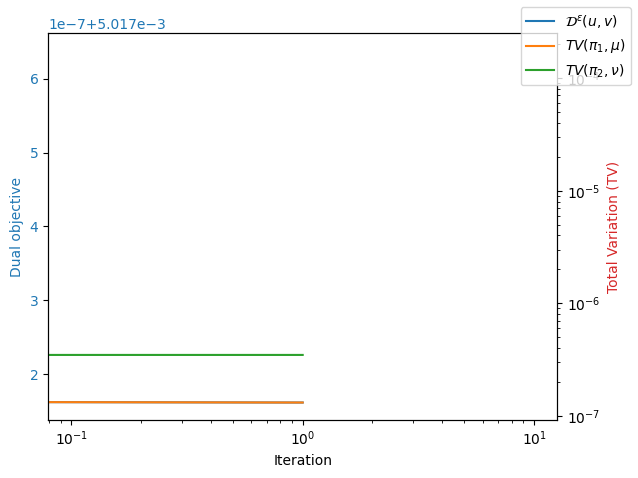

In [477]:
plot_sinkhorn_history(sinkhorn_history)

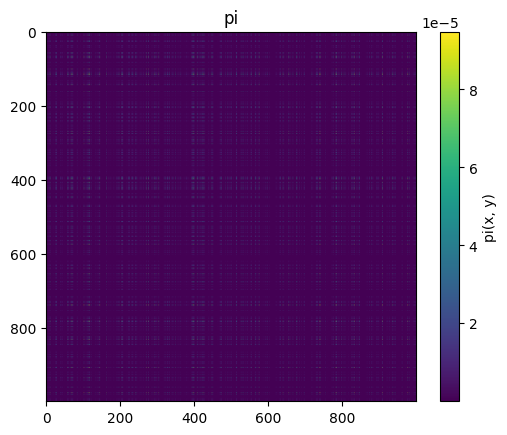

In [478]:
plt.imshow(pi, cmap='viridis')
plt.colorbar(label="pi(x, y)")
plt.title("pi")
plt.show()

In [479]:
force_mlp = False
lr = 1e-2 if force_mlp else 1e2
u, v, dual_history = stochastic_dual(
    X1, X2, mu, nu, epsilon=epsilon, batch_size=batch_size, n_iter=1000, lr=lr, record_history=True, pi_GT=pi_sinkhorn, force_mlp=force_mlp
)
if not force_mlp:
    u_values = u
    v_values = v
else:
    u_values = u(X1)[:, 0]
    v_values = v(X2)[:, 0]
pi = (
        np.exp((u_values[:, None].detach() + v_values[None, :].detach() - C[:, :].numpy()) / epsilon)
        * mu[:, None].numpy()
        * nu[None, :].numpy()
    )

print("\nOT plan from Algo 1 :")
print("Sum :", pi.sum())
print("Marginals TV :", (pi.sum(axis=0) - nu).abs().sum(), (pi.sum(axis=1) - mu).abs().sum())
print("TV to Sinkhorn :", np.abs(pi - pi_sinkhorn).sum())

# closed form projection
pi_tilde, L = closed_form_projection(X1, X2, mu, nu, u, v, epsilon=epsilon, sinkhorn=False, record_history=True)
print("Monge map from Algo 1 :")
print("MSE :", (pi_tilde - X1).pow(2).mean())

# learning the map
T, map_history = discrete_map_learning(u, v, epsilon, X1, X2, mu, nu, batch_size=batch_size, lr=1e-2, n_iter=1000, record_history=True, Monge_map=pi_tilde)
print("Monge map from Algo 2 :")
print("MSE :", (T(X1) - X1).pow(2).mean())


OT plan from Algo 1 :
Sum : tensor(1.0000)
Marginals TV : tensor(9.0643e-05) tensor(9.0518e-05)
TV to Sinkhorn : tensor(0.0002)
Monge map from Algo 1 :
MSE : tensor(0.0008)
Monge map from Algo 2 :
MSE : tensor(0.0008, grad_fn=<MeanBackward0>)


In [480]:
print(dual_history.keys())
print(dual_history["dual"][-1])
print(dual_history["primal"][-1])
print(dual_history["Transport Cost"][-1])

dict_keys(['Transport Cost', 'primal', 'dual', 'time', 'nsamples', 'iter', 'TV_to_mu', 'TV_to_nu', 'TV(pi, pi_GT)'])
0.005171239376068115
-8.854594230651855
0.005383338313549757


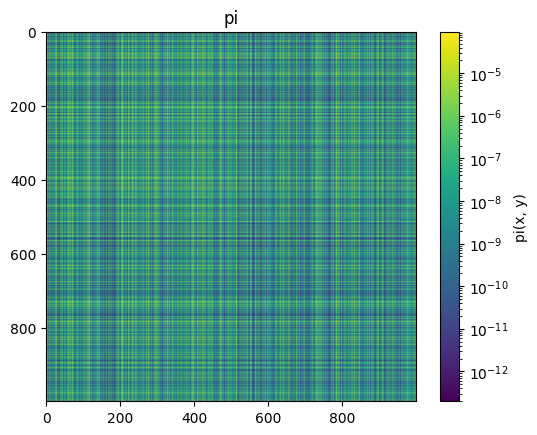

In [481]:
plt.imshow(pi, cmap='viridis', norm=LogNorm())
plt.colorbar(label="pi(x, y)", norm=LogNorm())
plt.title("pi")
plt.show()

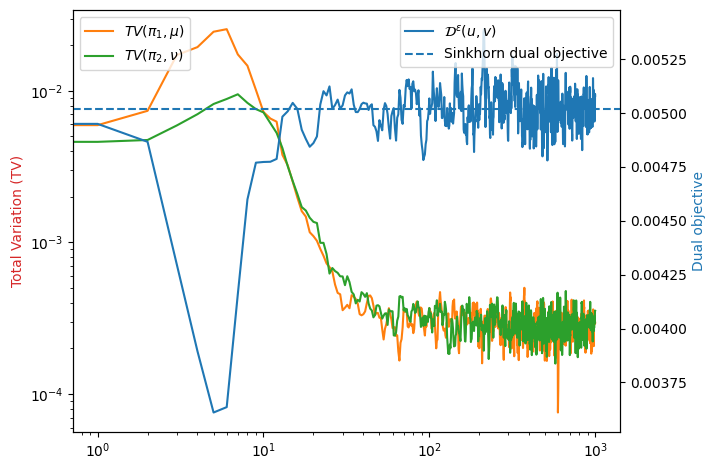

In [482]:
plot_dual_history(dual_history, sinkhorn_history)

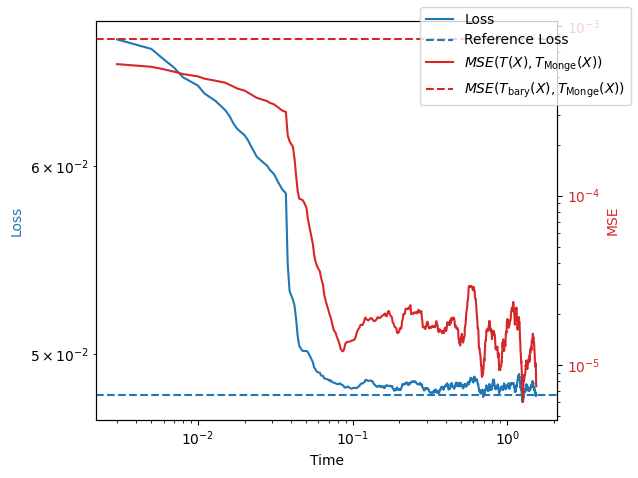

In [483]:
plot_map_history(map_history, L.item(), (pi_tilde - X1).pow(2).mean().item())

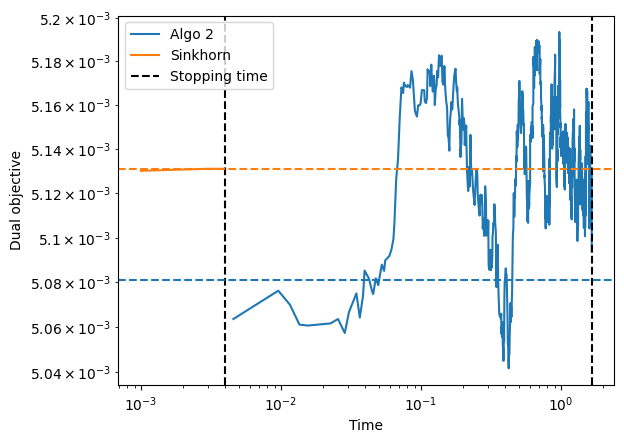

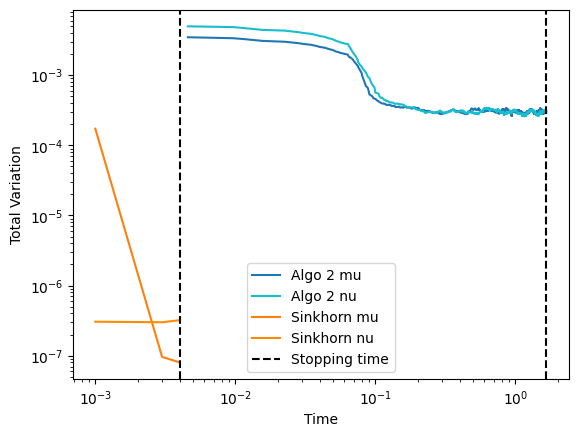

In [432]:
# make the following plot :
# Dual vs Time for sinkhorn and algo 1

# keep the same length
smoothed_dual = dual_history["dual"]
def smooth(data, window_size=50):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)
smoothed_dual = smooth(dual_history["dual"])

plt.loglog(dual_history["time"], smoothed_dual, label="Algo 2", color='tab:blue')
plt.loglog(sinkhorn_history["time"], sinkhorn_history["dual"], label="Sinkhorn", color='tab:orange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["time"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["time"][-1], linestyle='--', label='Stopping time', color='black')
plt.axhline(y=dual_history["dual"][-1], linestyle='--', color='tab:blue')
plt.axhline(y=sinkhorn_history["dual"][-1], linestyle='--', color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Dual objective")
plt.legend()
plt.show()

# Now, do TV vs Time for sinkhorn and algo 1

smoothed_mu = smooth(dual_history["TV_to_mu"])
smoothed_nu = smooth(dual_history["TV_to_nu"])
plt.loglog(dual_history["time"], smoothed_mu, label="Algo 2 mu", color='tab:blue')
plt.loglog(dual_history["time"], smoothed_nu, label="Algo 2 nu", color='tab:cyan')
plt.loglog(sinkhorn_history["time"], sinkhorn_history["TV_to_mu"], label="Sinkhorn mu", color='tab:orange')
plt.loglog(sinkhorn_history["time"], sinkhorn_history["TV_to_nu"], label="Sinkhorn nu", color='darkorange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["time"][-1], linestyle='--', label='Stopping time', color='black')
plt.axvline(x=sinkhorn_history["time"][-1], linestyle='--', color='black')
plt.xlabel("Time")
plt.ylabel("Total Variation")
plt.legend()
plt.show()

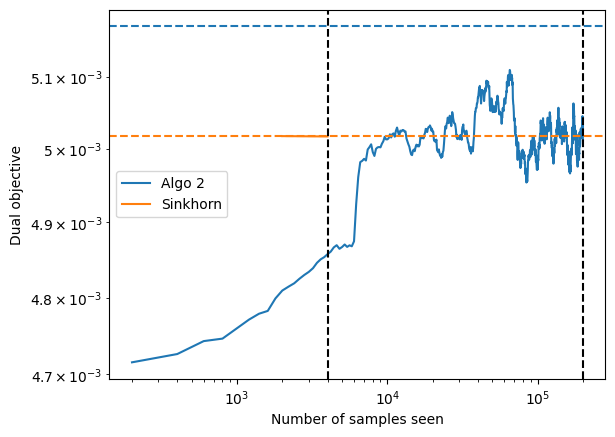

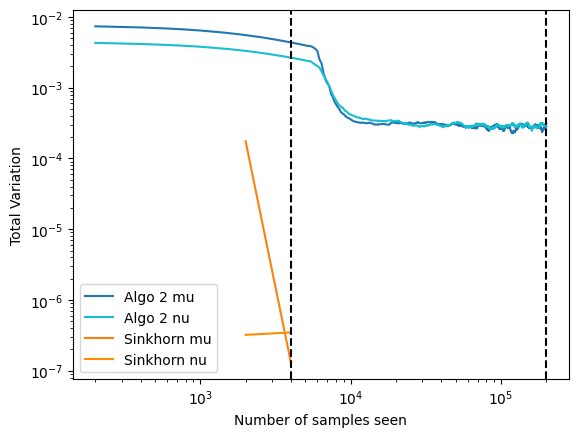

In [484]:
# make the following plot :
# Dual vs Time for sinkhorn and algo 1

# keep the same length
smoothed_dual = dual_history["dual"]
def smooth(data, window_size=50):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)
smoothed_dual = smooth(dual_history["dual"])

plt.loglog(dual_history["nsamples"], smoothed_dual, label="Algo 2", color='tab:blue')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["dual"], label="Sinkhorn", color='tab:orange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["nsamples"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["n_samples"][-1], linestyle='--', color='black')
plt.axhline(y=dual_history["dual"][-1], linestyle='--', color='tab:blue')
plt.axhline(y=sinkhorn_history["dual"][-1], linestyle='--', color='tab:orange')
plt.xlabel("Number of samples seen")
plt.ylabel("Dual objective")
plt.legend()
plt.show()

# Now, do TV vs Time for sinkhorn and algo 1

smoothed_mu = smooth(dual_history["TV_to_mu"])
smoothed_nu = smooth(dual_history["TV_to_nu"])
plt.loglog(dual_history["nsamples"], smoothed_mu, label="Algo 2 mu", color='tab:blue')
plt.loglog(dual_history["nsamples"], smoothed_nu, label="Algo 2 nu", color='tab:cyan')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["TV_to_mu"], label="Sinkhorn mu", color='tab:orange')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["TV_to_nu"], label="Sinkhorn nu", color='darkorange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["nsamples"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["n_samples"][-1], linestyle='--', color='black')
plt.xlabel("Number of samples seen")
plt.ylabel("Total Variation")
plt.legend()
plt.show()

In [485]:
# Toy test case : X1, X2 ~ W1 * N(0, 1) + b1, W2 * N(0, 1) + b2

n_samples = 10000
batch_size = 200
n_features = 3
sigma = 1e0
def random_orthogonal_matrix(n):
    W1 = torch.randn(n, n)
    W1 = W1 @ W1.T
    U, S, V = torch.svd(W1)
    max_singular_value = S.max()
    S = S / max_singular_value * sigma
    W1 = U @ torch.diag(S) @ V.T
    return W1

# W1 = random_orthogonal_matrix(n_features)
# b1 = torch.randn(n_features)
X1 = torch.einsum('dD, nD -> nd', W1, torch.randn(n_samples, n_features)) + b1

# W2 = random_orthogonal_matrix(n_features)
# b2 = torch.randn(n_features)
X2 = torch.einsum('dD, nD -> nd', W2, torch.randn(n_samples, n_features)) + b2

T_monge = closed_form_gaussian_T(b1, W1, b2, W2)
Monge_map = T_monge(X1)

mu = torch.ones(n_samples) / n_samples
nu = mu

C = torch.cdist(X1, X2, p=2) ** 2

epsilon = 1e0

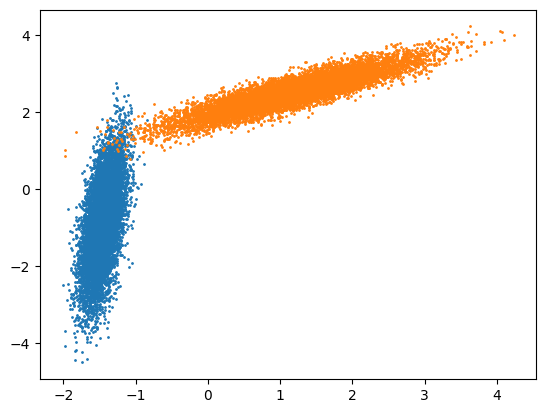

In [486]:
# plot the two distributions :
plt.scatter(X1[:, 0], X1[:, 1], label='X1', s=1)
plt.scatter(X2[:, 0], X2[:, 1], label='X2', s=1)
plt.show()

In [487]:
pi_opt = closed_form_gaussian_pi(b1, W1, b2, W2, epsilon)
pi_opt = pi_opt(X1, X2)
pi_opt = pi_opt / pi_opt.sum()

In [488]:
import importlib
import sinkhorn
importlib.reload(sinkhorn)
from sinkhorn import sinkhorn
u, v, pi, sinkhorn_history = sinkhorn(X1, X2, mu, nu, epsilon=epsilon, n_iter=100, tol=1e-6, return_pi=True, record_history=True, pi_GT=pi_opt)
# print(u, v)
# print(pi)
pi_sink = pi
print("OT plan from Sinkhorn :")
print("Sum :", pi.sum())
print("Marginals TV :", (pi.sum(axis=0) - nu).abs().sum(), (pi.sum(axis=1) - mu).abs().sum())
print("TV(pi, pi_opt) :", (pi - pi_opt).abs().sum())

# closed form projection

pi_tilde, L = closed_form_projection(X1, X2, mu, nu, u, v, epsilon=epsilon, sinkhorn=True, record_history=True)
print("Monge map from Sinkhorn :")
print("MSE pi_tilde - X1 :", (pi_tilde - X1).pow(2).mean())
print("MSE pi_tilde - X2 :", (pi_tilde - X2).pow(2).mean())
print("MSE pi_tilde - Monge_map :", (pi_tilde - Monge_map).pow(2).mean())
print("Loss :", L)

OT plan from Sinkhorn :
Sum : tensor(0.9444)
Marginals TV : tensor(0.0556) tensor(0.0556)
TV(pi, pi_opt) : tensor(0.5055)
Monge map from Sinkhorn :
MSE pi_tilde - X1 : tensor(5.6219)
MSE pi_tilde - X2 : tensor(0.5249)
MSE pi_tilde - Monge_map : tensor(0.0693)
Loss : tensor(0.6123)


In [489]:
print(sinkhorn_history.keys())
print(sinkhorn_history["dual"][-1])
print(sinkhorn_history["primal"][-1])
print(sinkhorn_history["Transport Cost"][-1])

dict_keys(['Transport Cost', 'primal', 'dual', 'iter', 'n_samples', 'time', 'TV_to_mu', 'TV_to_nu', 'TV(pi, pi_GT)'])
19.579492568969727
-0.16064453125
17.981901168823242


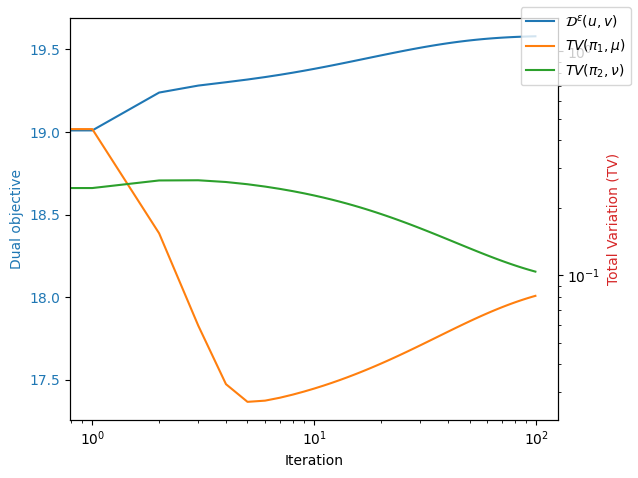

In [490]:
plot_sinkhorn_history(sinkhorn_history)

In [491]:
# # plot the transport plan :
# plt.imshow(pi, cmap='hot', interpolation='nearest')
# plt.colorbar(label="pi(x, y)")
# plt.title("pi")
# plt.show()

In [492]:
import importlib
import stochastic
import closed_form
import utils
importlib.reload(stochastic)
importlib.reload(utils)
importlib.reload(closed_form)
from stochastic import stochastic_dual, discrete_map_learning
from closed_form import closed_form_projection
force_mlp = False
lr = 5e2 if not force_mlp else 1e-2
u, v, dual_history = stochastic_dual(
    X1, X2, mu, nu, epsilon=epsilon, batch_size=batch_size, n_iter=100000, lr=lr, record_history=True, pi_GT=pi_sink, force_mlp=force_mlp
)
u_values = u(X1)[:, 0] if isinstance(u, torch.nn.Module) else u
v_values = v(X2)[:, 0] if isinstance(v, torch.nn.Module) else v

pi = (
    np.exp((u_values[:, None].detach() + v_values[None, :].detach() - C[:, :].numpy()) / epsilon)
    * mu[:, None].numpy()
    * nu[None, :].numpy()
)

print("\nOT plan from Algo 1 :")
print("Sum :", pi.sum())
print("Marginals TV :", (pi.sum(axis=0) - nu).abs().sum(), (pi.sum(axis=1) - mu).abs().sum())
print("TV(pi, pi_GT) :", np.abs(pi - pi_sink).sum())

# closed form projection
pi_tilde, L = closed_form_projection(X1, X2, mu, nu, u, v, epsilon=epsilon, sinkhorn=False, record_history=True)
print("Monge map from Algo 1 :")
print("MSE pi_tilde - X1 :", (pi_tilde - X1).pow(2).mean())
print("MSE pi_tilde - X2 :", (pi_tilde - X2).pow(2).mean())
print("MSE pi_tilde - Monge_map :", (pi_tilde - Monge_map).pow(2).mean())

# learning the map
T, map_history = discrete_map_learning(u, v, epsilon, X1, X2, mu, nu, batch_size=batch_size, lr=1e-2, n_iter=1000, record_history=True, Monge_map=Monge_map)
print("Monge map from Algo 2 :")
print("MSE T(X1) - X1 :", (T(X1) - X1).pow(2).mean())
print("MSE T(X1) - X2 :", (T(X1) - X2).pow(2).mean())
print("MSE T(X1) - Monge_map :", (T(X1) - Monge_map).pow(2).mean())


OT plan from Algo 1 :
Sum : tensor(0.9951)
Marginals TV : tensor(0.0132) tensor(0.0147)
TV(pi, pi_GT) : tensor(0.1598)
Monge map from Algo 1 :
MSE pi_tilde - X1 : tensor(6.2134)
MSE pi_tilde - X2 : tensor(0.4845)
MSE pi_tilde - Monge_map : tensor(0.0323)
Monge map from Algo 2 :
MSE T(X1) - X1 : tensor(6.2244, grad_fn=<MeanBackward0>)
MSE T(X1) - X2 : tensor(0.4576, grad_fn=<MeanBackward0>)
MSE T(X1) - Monge_map : tensor(0.0387, grad_fn=<MeanBackward0>)


In [493]:
print("Transport cost monge :", (Monge_map - X1).pow(2).mean())

Transport cost monge : tensor(6.2084)


In [494]:
print(dual_history.keys())
print(dual_history["dual"][-1])
print(dual_history["primal"][-1])
print(dual_history["Transport Cost"][-1])

dict_keys(['Transport Cost', 'primal', 'dual', 'time', 'nsamples', 'iter', 'TV_to_mu', 'TV_to_nu', 'TV(pi, pi_GT)'])
18.857595443725586
8.462814331054688
18.754924774169922


In [495]:
n_test = 1000
X_test = torch.einsum('dD, nD -> nd', W1, torch.randn(n_test, n_features)) + b1
Y_test = T(X_test)
Monge_test = T_monge(X_test)

print("MSE T(X_test) - T_monge(X_test) :", (Y_test - Monge_test).pow(2).mean())

MSE T(X_test) - T_monge(X_test) : tensor(0.0390, grad_fn=<MeanBackward0>)


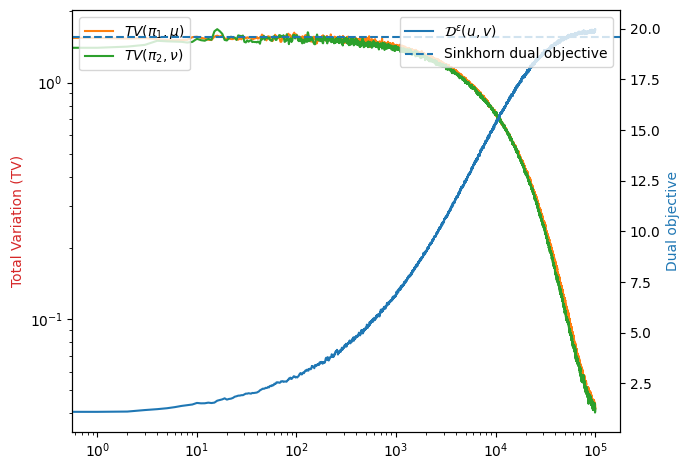

In [496]:
plot_dual_history(dual_history, sinkhorn_history)

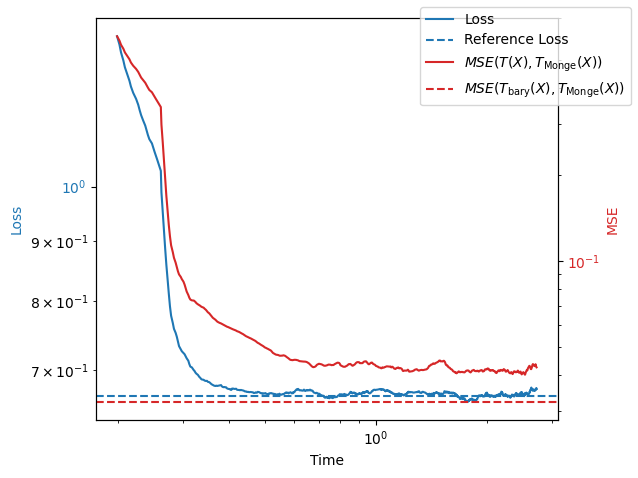

In [497]:
plot_map_history(map_history, L.item(), (pi_tilde - Monge_map).pow(2).mean().item())

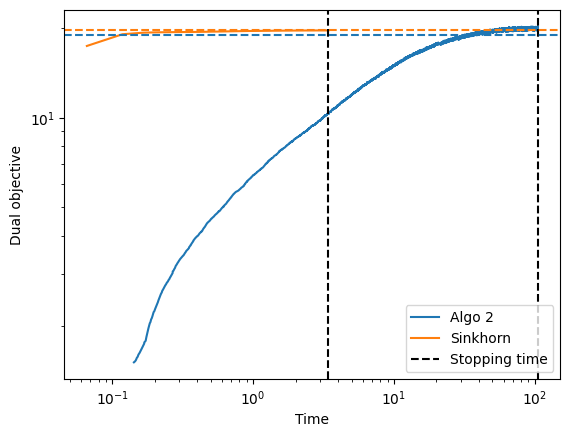

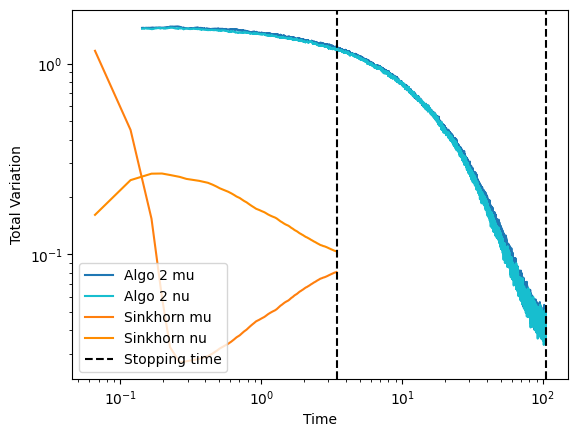

In [498]:
# make the following plot :
# Dual vs Time for sinkhorn and algo 1

# keep the same length
smoothed_dual = dual_history["dual"]
def smooth(data, window_size=50):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)
smoothed_dual = smooth(dual_history["dual"])

plt.loglog(dual_history["time"], smoothed_dual, label="Algo 2", color='tab:blue')
plt.loglog(sinkhorn_history["time"], sinkhorn_history["dual"], label="Sinkhorn", color='tab:orange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["time"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["time"][-1], linestyle='--', label='Stopping time', color='black')
plt.axhline(y=dual_history["dual"][-1], linestyle='--', color='tab:blue')
plt.axhline(y=sinkhorn_history["dual"][-1], linestyle='--', color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Dual objective")
plt.legend()
plt.show()

# Now, do TV vs Time for sinkhorn and algo 1

smoothed_mu = smooth(dual_history["TV_to_mu"])
smoothed_nu = smooth(dual_history["TV_to_nu"])
plt.loglog(dual_history["time"], smoothed_mu, label="Algo 2 mu", color='tab:blue')
plt.loglog(dual_history["time"], smoothed_nu, label="Algo 2 nu", color='tab:cyan')
plt.loglog(sinkhorn_history["time"], sinkhorn_history["TV_to_mu"], label="Sinkhorn mu", color='tab:orange')
plt.loglog(sinkhorn_history["time"], sinkhorn_history["TV_to_nu"], label="Sinkhorn nu", color='darkorange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["time"][-1], linestyle='--', label='Stopping time', color='black')
plt.axvline(x=sinkhorn_history["time"][-1], linestyle='--', color='black')
plt.xlabel("Time")
plt.ylabel("Total Variation")
plt.legend()
plt.show()

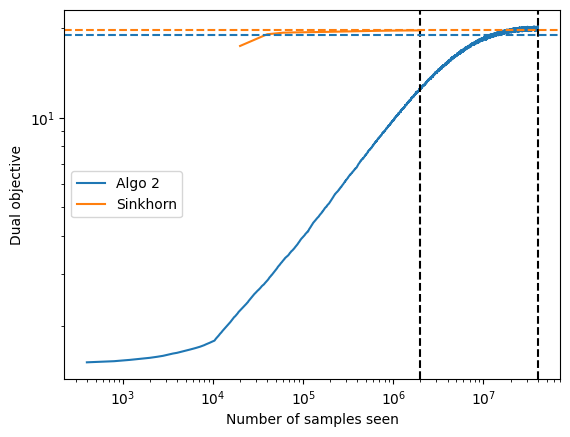

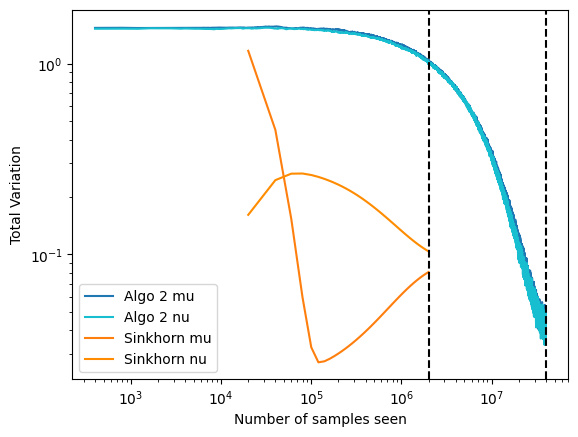

In [499]:
# make the following plot :
# Dual vs Time for sinkhorn and algo 1

# keep the same length
smoothed_dual = dual_history["dual"]
def smooth(data, window_size=50):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)
smoothed_dual = smooth(dual_history["dual"])

plt.loglog(dual_history["nsamples"], smoothed_dual, label="Algo 2", color='tab:blue')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["dual"], label="Sinkhorn", color='tab:orange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["nsamples"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["n_samples"][-1], linestyle='--', color='black')
plt.axhline(y=dual_history["dual"][-1], linestyle='--', color='tab:blue')
plt.axhline(y=sinkhorn_history["dual"][-1], linestyle='--', color='tab:orange')
plt.xlabel("Number of samples seen")
plt.ylabel("Dual objective")
plt.legend()
plt.show()

# Now, do TV vs Time for sinkhorn and algo 1

smoothed_mu = smooth(dual_history["TV_to_mu"])
smoothed_nu = smooth(dual_history["TV_to_nu"])
plt.loglog(dual_history["nsamples"], smoothed_mu, label="Algo 2 mu", color='tab:blue')
plt.loglog(dual_history["nsamples"], smoothed_nu, label="Algo 2 nu", color='tab:cyan')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["TV_to_mu"], label="Sinkhorn mu", color='tab:orange')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["TV_to_nu"], label="Sinkhorn nu", color='darkorange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["nsamples"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["n_samples"][-1], linestyle='--', color='black')
plt.xlabel("Number of samples seen")
plt.ylabel("Total Variation")
plt.legend()
plt.show()

In [500]:
# Toy test case : continuous distributions, mu = N(b1, W1), nu = N(b2, W2)
mu = torch.distributions.MultivariateNormal(b1, W1)
nu = torch.distributions.MultivariateNormal(b2, W2)

T_monge = closed_form_gaussian_T(b1, W1, b2, W2)

batch_size = 200
epsilon = 1e0

In [501]:
pi_opt = closed_form_gaussian_pi(b1, W1, b2, W2, epsilon)

batch_size_estimation = 10000
X1_batch = mu.sample((batch_size_estimation,))
X2_batch = nu.sample((batch_size_estimation,))
C = torch.cdist(X1_batch, X2_batch, p=2) ** 2
pi_opt_batch = pi_opt(X1_batch, X2_batch)
pi_opt_batch = pi_opt_batch / pi_opt_batch.sum()
transport_cost = torch.sum(pi_opt_batch * C)
primal = torch.sum(pi_opt_batch * C) + epsilon * torch.sum(pi_opt_batch * (torch.log(pi_opt_batch + 1e-20)))
print(f"Transport cost: {transport_cost}")
print(f"Primal: {primal}")

X1_prob = mu.log_prob(X1_batch).exp()
X2_prob = nu.log_prob(X2_batch).exp()
X1_prob = X1_prob / X1_prob.sum()
X2_prob = X2_prob / X2_prob.sum()

print("TV(mu, pi_opt) :", (X1_prob - pi_opt_batch.sum(axis=1)).abs().sum())
print("TV(nu, pi_opt) :", (X2_prob - pi_opt_batch.sum(axis=0)).abs().sum())

Transport cost: 19.01844024658203
Primal: 1.412027359008789
TV(mu, pi_opt) : tensor(0.0742)
TV(nu, pi_opt) : tensor(0.0752)


In [502]:
# pi_sink = None : no sinkhorn in continuous cases

In [503]:
import importlib
import stochastic
import utils
importlib.reload(stochastic)
importlib.reload(utils)
from stochastic import stochastic_dual
u, v, dual_history = stochastic_dual(
    mu=mu, nu=nu, epsilon=epsilon, batch_size=batch_size, n_iter=100000, lr=1e-2, record_history=True, pi_GT=pi_opt
)
print("OT plan from Algo 1 :")
print("Marginals TV :", dual_history["TV_to_mu"][-1], dual_history["TV_to_nu"][-1])
print("TV(pi, pi_GT) :", dual_history["TV(pi, pi_GT)"][-1])
print("Dual objective :", dual_history["dual"][-1])

# # closed form projection
# pi_tilde, L = None in continuous case

# learning the map
# T, map_history = continuous_map_learning(u, v, epsilon, mu, nu, batch_size=batch_size, lr=1e-2, n_iter=1000, record_history=True, Monge_map=T_monge)

OT plan from Algo 1 :
Marginals TV : 0.11543089896440506 0.10028515756130219
TV(pi, pi_GT) : tensor(0.1356)
Dual objective : 19.60443687438965


In [504]:
print(dual_history.keys())
print(dual_history["dual"][-1])
print(dual_history["primal"][-1])
print(dual_history["Transport Cost"][-1])
print(dual_history["TV_to_mu"][-1])
print(dual_history["TV_to_nu"][-1])

dict_keys(['Transport Cost', 'primal', 'dual', 'time', 'nsamples', 'iter', 'TV_to_mu', 'TV_to_nu', 'TV(pi, pi_GT)'])
19.60443687438965
8.805891036987305
18.48240089416504
0.11543089896440506
0.10028515756130219


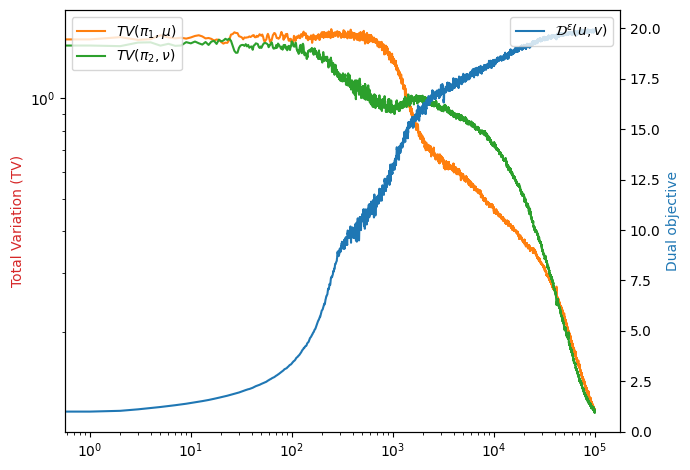

In [505]:
plot_dual_history(dual_history, None, plot_TV=True)

In [506]:
import stochastic
import importlib
importlib.reload(stochastic)
from stochastic import continuous_map_learning
T, map_history = continuous_map_learning(
    u=u, v=v, epsilon=epsilon, mu=mu, nu=nu, batch_size=batch_size, lr=2e-2, n_iter=1000, record_history=True, Monge_map=T_monge
)
print("Monge map from Algo 2 :")
print("MSE T(X1) - Monge :", map_history["MSE T(X1) - Monge_map"][-1])

plot_map_history(map_history, None, None)

KeyboardInterrupt: 

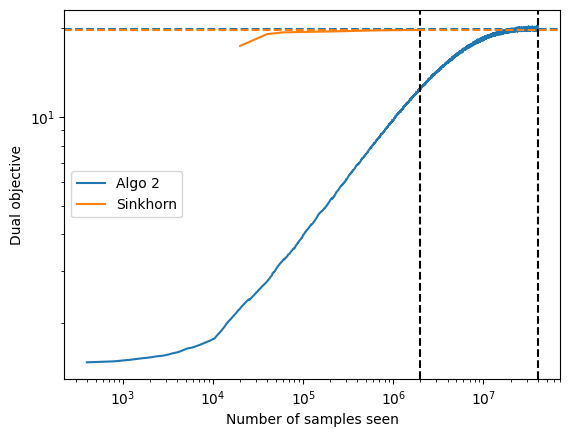

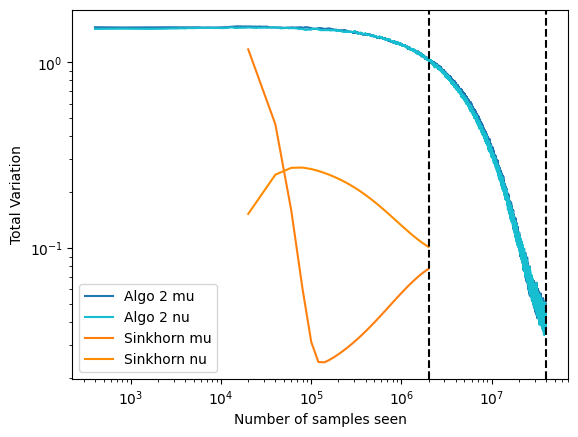

In [ ]:
# make the following plot :
# Dual vs Time for sinkhorn and algo 1

# keep the same length
smoothed_dual = dual_history["dual"]
def smooth(data, window_size=50):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)
smoothed_dual = smooth(dual_history["dual"])

plt.loglog(dual_history["nsamples"], smoothed_dual, label="Algo 2", color='tab:blue')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["dual"], label="Sinkhorn", color='tab:orange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["nsamples"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["n_samples"][-1], linestyle='--', color='black')
plt.axhline(y=dual_history["dual"][-1], linestyle='--', color='tab:blue')
plt.axhline(y=sinkhorn_history["dual"][-1], linestyle='--', color='tab:orange')
plt.xlabel("Number of samples seen")
plt.ylabel("Dual objective")
plt.legend()
plt.show()

# Now, do TV vs Time for sinkhorn and algo 1

smoothed_mu = smooth(dual_history["TV_to_mu"])
smoothed_nu = smooth(dual_history["TV_to_nu"])
plt.loglog(dual_history["nsamples"], smoothed_mu, label="Algo 2 mu", color='tab:blue')
plt.loglog(dual_history["nsamples"], smoothed_nu, label="Algo 2 nu", color='tab:cyan')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["TV_to_mu"], label="Sinkhorn mu", color='tab:orange')
plt.loglog(sinkhorn_history["n_samples"], sinkhorn_history["TV_to_nu"], label="Sinkhorn nu", color='darkorange')
# plot a vertical line when sinkhorn is done
plt.axvline(x=dual_history["nsamples"][-1], linestyle='--', color='black')
plt.axvline(x=sinkhorn_history["n_samples"][-1], linestyle='--', color='black')
plt.xlabel("Number of samples seen")
plt.ylabel("Total Variation")
plt.legend()
plt.show()